In [1]:
abstract Layer

# Kinda like a C struct
type StandardScalar
    mean::Vector{Float64}
    std::Vector{Float64}
end

# Helper function to initialize an empty scalar
function StandardScalar()
    StandardScalar(Array(Float64,0),Array(Float64,0))
end

# Compute mean and standard deviation of each column
function fit_std_scalar!(std_scalar::StandardScalar,X::Matrix{Float64})
    n_rows, n_cols = size(X)
    std_scalar.std = zeros(n_rows)
    std_scalar.mean = zeros(n_rows)
    # for loops are fast again!
    for i = 1:n_rows
        std_scalar.mean[i] = mean(X[i,:])
        std_scalar.std[i] = std(X[i,:])
    end
end

function transform(std_scalar::StandardScalar,X::Matrix{Float64})
    (X .- std_scalar.mean) ./ std_scalar.std # broadcasting fu
end

# fit and transform in one function
function fit_transform!(std_scalar::StandardScalar,X::Matrix{Float64})
    fit_std_scalar!(std_scalar,X)
    transform(std_scalar,X)
end

# append vertical
function appendColumnOfOnes(a::Array{Float64,2})
    vcat(a,ones(1,size(a ,2)))
end

# params: horizontal
# input: vertical
function sigmoidNeuronTransformFunction(params, input)
  return 1.0 ./ (1.0 .+ exp(-params * appendColumnOfOnes(input)))
end

function linearNeuronTransformFunction(params, input)
  return params * appendColumnOfOnes(input)
end

function exponentialNormalizer(params, input)
  denominator = sum(exp(input),1)
  return exp(input) ./ denominator
end

type FullyConnectedComputingLayer <: Layer
  inputSize::Int64
  numberOfNeurons::Int64
  parameters::Array{Float64,2}
  transform::Function
  derivative::Function # derivative added here

  function FullyConnectedComputingLayer(inputSize, numberOfNeurons, transform::Function, derivative::Function)
    parameters = randn(numberOfNeurons, inputSize + 1)  * 0.1 # adding one param column for bias
    return new(inputSize, numberOfNeurons, parameters, transform, derivative)
  end
end

type SoftMaxLayer <: Layer
  numberOfNeurons::Int64
  parameters::Any
  transform::Function

  function SoftMaxLayer(numberOfNeurons)
    return new(numberOfNeurons, [], exponentialNormalizer)
  end
end

type NetworkArchitecture
  layers::Array{Layer}
  function NetworkArchitecture(firstLayer::Layer)
    return new([firstLayer])
  end
end

function addSoftMaxLayer(architecture::NetworkArchitecture)
 lastNetworkLayer = architecture.layers[end]
 numberOfNeurons = lastNetworkLayer.numberOfNeurons
 softMaxLayer = SoftMaxLayer(numberOfNeurons)
 push!(architecture.layers, softMaxLayer)
end

function addFullyConnectedSigmoidLayer(arch::NetworkArchitecture, numberOfNeurons::Int64)
 lastNetworkLayer = arch.layers[end]
 inputSize = lastNetworkLayer.numberOfNeurons
 #derivative added
 sigmoidLayer = FullyConnectedComputingLayer(inputSize, numberOfNeurons, sigmoidNeuronTransformFunction, x -> x .* (1 - x))
 push!(arch.layers, sigmoidLayer)
end

function addFullyConnectedLinearLayer(architecture::NetworkArchitecture, numberOfNeurons::Int64)
 lastNetworkLayer = architecture.layers[end]
 inputSize = lastNetworkLayer.numberOfNeurons
 linearLayer = FullyConnectedComputingLayer(inputSize, numberOfNeurons, linearNeuronTransformFunction, x -> 1)
 push!(architecture.layers, linearLayer)
end

function infer(architecture::NetworkArchitecture, input)
  currentResult = input
  for i in 1:length(architecture.layers)
     layer = architecture.layers[i]
     currentResult = layer.transform(layer.parameters, currentResult)
  end
  return currentResult
end

function crossEntropyError(architecture::NetworkArchitecture, input, labels)
 probabilitiesSparseMatrix = infer(architecture, input) .* labels
 probabilities = sum(probabilitiesSparseMatrix , 1)
 return -mean(log(probabilities))
end

type BackPropagationBatchLearningUnit
  networkArchitecture::NetworkArchitecture
  dataBatch::Array{Float64,2}
  labels::AbstractSparseMatrix
  outputs::Array{Array{Float64,2}} # outputs remembered now
  deltas::Array{Array{Float64,2}} # deltas kept here

  function BackPropagationBatchLearningUnit(arch::NetworkArchitecture, dataBatch::Array{Float64,2}, labels::AbstractSparseMatrix)
     outputs = [ zeros(l.numberOfNeurons, size(dataBatch,2)) for l in arch.layers ]
     deltas = [ zeros(l.numberOfNeurons, size(dataBatch,2)) for l in arch.layers ]
     return new(arch, dataBatch, labels, outputs, deltas)
  end
end

function forwardPass!(learningUnit::BackPropagationBatchLearningUnit)
  currentResult = learningUnit.dataBatch
  for i in 1:length(learningUnit.networkArchitecture.layers)
     layer = learningUnit.networkArchitecture.layers[i]
     currentResult = layer.transform(layer.parameters, currentResult)
     learningUnit.outputs[i]  = currentResult
  end
end

function backwardPass!(learningUnit::BackPropagationBatchLearningUnit)

  layer = learningUnit.networkArchitecture.layers[end-1]
  learningUnit.deltas[end-1]  = layer.derivative(learningUnit.outputs[end-1]) .*  (learningUnit.outputs[end] - learningUnit.labels)

  for i in 2:(length(learningUnit.networkArchitecture.layers) - 1)
      higherLayer = learningUnit.networkArchitecture.layers[end - i + 1]
      currentLayer = learningUnit.networkArchitecture.layers[end - i]
      learningUnit.deltas[end-i] = currentLayer.derivative(learningUnit.outputs[end-i]) .* (transpose(higherLayer.parameters[:,(1:end-1)]) * learningUnit.deltas[end - i + 1])
  end
end

function updateParameters!(unit::BackPropagationBatchLearningUnit, learningRate)
  forwardPass!(unit)
  backwardPass!(unit)
  derivativeW= (unit.deltas[1] * transpose(unit.dataBatch)) / size(unit.dataBatch,2);
  unit.networkArchitecture.layers[1].parameters[:,1:(end-1)] = unit.networkArchitecture.layers[1].parameters[:,1:(end-1)] - learningRate * derivativeW;
  derivativeB = mean(unit.deltas[1],2);
  unit.networkArchitecture.layers[1].parameters[:,end] =  unit.networkArchitecture.layers[1].parameters[:,end] - learningRate * derivativeB;
  for i in 2:(length(unit.networkArchitecture.layers) - 1)
    derivativeW = (unit.deltas[i] * transpose(unit.outputs[i-1])) / size(unit.dataBatch,2);
    unit.networkArchitecture.layers[i].parameters[:,1:(end-1)] = unit.networkArchitecture.layers[i].parameters[:,1:(end-1)] - learningRate * derivativeW;
    derivativeB = mean(unit.deltas[i],2);
    unit.networkArchitecture.layers[i].parameters[:,end] =  unit.networkArchitecture.layers[i].parameters[:,end] - learningRate * derivativeB;
  end
end

# helper to build SoftMax architecture
function buildNetworkArchitectureSoftMax(sizes)
  firstLayer = FullyConnectedComputingLayer(sizes[1], sizes[2], linearNeuronTransformFunction, x -> 1);
  architecture = NetworkArchitecture(firstLayer);
  addSoftMaxLayer(architecture)
  return(architecture)
end

# helper to build an architecture with hidden sigmoid layers
function buildNetworkArchitectureWithOneHiddenSigmoids(sizes)
  firstLayer = FullyConnectedComputingLayer(sizes[1], sizes[2], sigmoidNeuronTransformFunction, x -> x .* (1 - x));
  architecture = NetworkArchitecture(firstLayer);
  for i in 3:(length(sizes)-1)
    addFullyConnectedSigmoidLayer(architecture, sizes[i]);
  end
  addFullyConnectedLinearLayer(architecture, sizes[end]);
  addSoftMaxLayer(architecture)
  return(architecture)
end


buildNetworkArchitectureWithOneHiddenSigmoids (generic function with 1 method)

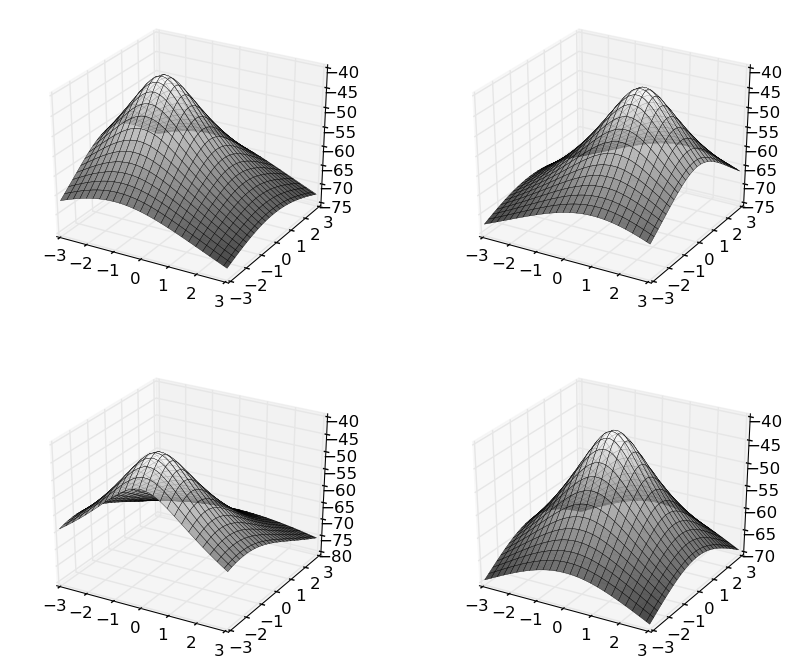

In [2]:
using PyPlot

n = 50
xn = yn = n
x = linspace(-3, 3, xn)
y = linspace(-3, 3, yn)

xgrid = repmat(x, 1, xn)';
ygrid = repmat(y, 1, yn);

type Antenna
    x::Float64
    y::Float64
end

# 
#          _
#          |
#      X1--+--X2
#          |
#         X3
#

antennas = Antenna[]
push!(antennas, Antenna(-1, 0))
push!(antennas, Antenna(1, 0))
push!(antennas, Antenna(0, -2))
push!(antennas, Antenna(0, 0))

N_inputs = length(antennas)

fi(a, x, y) = 1./((x.-antennas[a].x).^2 .+ (y.-antennas[a].y).^2 + 1)
_flogv(a, x, y) = -20*log((x.-antennas[a].x).^2 .+ (y.-antennas[a].y).^2 + 1)/2 - 40

flogv = _flogv

fig = figure("An example", figsize=(10,8));

ax = fig[:add_subplot](2,2,1, projection = "3d");
z = flogv(1,xgrid,ygrid)
ax[:plot_surface](xgrid, ygrid, z, rstride=2, cstride=2, cmap=ColorMap("gray"), alpha=0.7, linewidth=0.25)

ax = fig[:add_subplot](2,2,2, projection = "3d");
z = flogv(2,xgrid,ygrid)
ax[:plot_surface](xgrid, ygrid, z, rstride=2, cstride=2, cmap=ColorMap("gray"), alpha=0.7, linewidth=0.25)

ax = fig[:add_subplot](2,2,3, projection = "3d");
z = flogv(3,xgrid,ygrid)
ax[:plot_surface](xgrid, ygrid, z, rstride=2, cstride=2, cmap=ColorMap("gray"), alpha=0.7, linewidth=0.25)

ax = fig[:add_subplot](2,2,4, projection = "3d");
z = flogv(4,xgrid,ygrid)
ax[:plot_surface](xgrid, ygrid, z, rstride=2, cstride=2, cmap=ColorMap("gray"), alpha=0.7, linewidth=0.25)

# fig[:subplots_adjust](left=.1,right=.9,top=.9,bottom=.1,wspace=.1,hspace=.1);
# show();


In [3]:
function tg3(x, y)
    if ((abs(x)<1) && (abs(y)<2))
        return 1
    else
        if (abs(y)<2)
            if ((x>=1) && (x<2))
                return 2
            elseif ((x<=-1) && (x>-2))
                return 3
            else
                return 0
            end
        else
            if ((y<=-2) && (y>-3) && (abs(x)<2))
                return 4
            else
                return 0
            end
        end
        return 0
    end
end

function gen_datain3(x, y)
    len = N_inputs
    rss = Array(Float64,(length(y),0)) 
    for i in 1:len
        rss = hcat(rss, flogv(i, x, y))
    end
    return rss
end

function gen_dataout(x, y)
    len = length(x)
    out = [tg3(x[i], y[i]) for i in 1:len]
    return out
end

function gen_rand(n)
    out = 2*5*rand(2, n)-5
    return out
end

function gen_randn(n)
    out = 2.5*randn(2, n)
    return out
end


gen_randn (generic function with 1 method)

In [4]:
N_train = 10000

println("generating training data")
# Rxy = 2*5*rand(2, N_train)-5
Rxy = gen_randn(N_train)

X_train = gen_datain3(Rxy[1,:], Rxy[2,:])'
y_train = gen_dataout(Rxy[1,:], Rxy[2,:])

# adapt
# X_train = (X_train .- mean(X_train,2)) / std(X_train .- mean(X_train,2))
std_scalar = StandardScalar()
X_train = fit_transform!(std_scalar,X_train)
y_train = sparse(convert(Array{Int64}, y_train + 1), 1:N_train, [1 for i in 1:N_train])

generating training data


5×10000 sparse matrix with 10000 Int64 nonzero entries:
	[1    ,     1]  =  1
	[1    ,     2]  =  1
	[2    ,     3]  =  1
	[1    ,     4]  =  1
	[2    ,     5]  =  1
	[1    ,     6]  =  1
	[2    ,     7]  =  1
	[1    ,     8]  =  1
	[3    ,     9]  =  1
	[1    ,    10]  =  1
	⋮
	[1    ,  9990]  =  1
	[1    ,  9991]  =  1
	[1    ,  9992]  =  1
	[1    ,  9993]  =  1
	[2    ,  9994]  =  1
	[2    ,  9995]  =  1
	[1    ,  9996]  =  1
	[3    ,  9997]  =  1
	[1    ,  9998]  =  1
	[1    ,  9999]  =  1
	[1    , 10000]  =  1

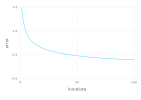

In [5]:
using Gadfly
# trainingData, trainingLabels, testData, testLabels = loadMnistData()
architecture = buildNetworkArchitectureSoftMax([4,5])
crossEntropies = Float64[]
for i = 1:100
  learningUnit = BackPropagationBatchLearningUnit(architecture, X_train, y_train);
  updateParameters!(learningUnit, 0.3)
  push!(crossEntropies, crossEntropyError(architecture, X_train, y_train))
end
Gadfly.plot(x = 1:length(crossEntropies), y = crossEntropies, Geom.line, Guide.xlabel("iterations"), Guide.ylabel("error"))

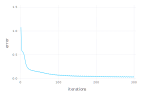

In [6]:
using Gadfly

architecture = buildNetworkArchitectureWithOneHiddenSigmoids([4,50,15,5]) # 50 neurons in a hidden layer now
crossEntropies = Float64[]
batchSize = 20
for i = 1:30000 
   minibatch = collect((batchSize*i):(batchSize*i +batchSize)) % size(y_train,2) + 1 # take next 20 elements 
   learningUnit = BackPropagationBatchLearningUnit(architecture, X_train[:,minibatch ], y_train[:,minibatch]);   
   updateParameters!(learningUnit, 0.3)
   if i % 100 == 0  # this one costs so lets store entropies every 100 iterations
     push!(crossEntropies, crossEntropyError(architecture, X_train, y_train))   
   end                 
end   
Gadfly.plot(x = 1:length(crossEntropies), y = crossEntropies, Geom.line, Guide.xlabel("iterations"), Guide.ylabel("error"))

In [7]:
N_test = 15000

mode = 0
if (mode == 1)
    Rxy = gen_randn(N_test)
else
    xn = yn = 100;
    N_test = xn*yn
    x = linspace(-4, 4, xn)
    y = linspace(-4, 4, yn)

    x = reshape(repmat(x', xn, 1), 1, length(repmat(x', xn, 1)))
    y = reshape(repmat(y, 1, yn), 1, length(repmat(y, 1, yn)))
    Rxy = [x;y]
end

X_test = gen_datain3(Rxy[1,:], Rxy[2,:])'
y_test = gen_dataout(Rxy[1,:], Rxy[2,:])

# adapt
# X_test = (X_test .- mean(X_test,2)) / std(X_test .- mean(X_test,2))
X_test = transform(std_scalar,X_test)
y_test = sparse(convert(Array{Int64}, y_test + 1),1:N_test, [ 1 for i in 1:N_test])

y_proba = infer(architecture, X_test)
mean(mapslices(x -> indmax(x), y_proba, 1)[:]  .==  mapslices(x -> indmax(x), full(y_test),1)[:])

0.9945

In [8]:
y_test_f = full(y_test)

r,c = size(y_test_f)
y_pred = Array(Int64,c)
y_test_full = Array(Int64,c)

for i in 1:c
    # must translate class index to label
    y_pred[i] = indmax(y_proba[:,i])
    y_test_full[i] = indmax(y_test_f[:,i])
end

println("Prediction accuracy: ", mean(y_pred .== y_test_full))

function confusion_matrix(y_true::Array{Int64,1},y_pred::Array{Int64,1})
    # Generate confusion matrix
    cm = zeros(Int64,5,5)

    for i in 1:c
        # translate label to index
        true_class = y_test_full[i]
        pred_class = y_pred[i]
        # pred class is the row, true class is the column
        cm[pred_class,true_class] += 1
    end
    cm
end

confusion_matrix(y_test_full,y_pred)

Prediction accuracy: 0.9945


5×5 Array{Int64,2}:
 6875     1    3    7    7
    0  1187    0    0    0
    9     8  647    0    0
    7     1    0  643    0
    9     3    0    0  593

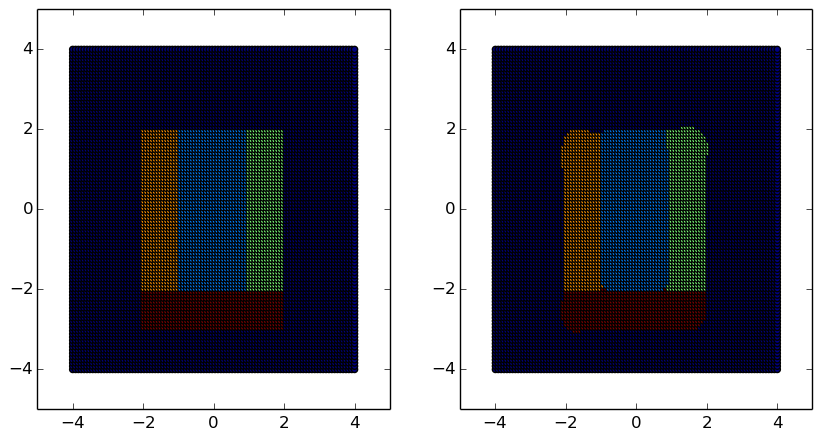

PyObject <matplotlib.collections.PathCollection object at 0x7f7bf242e210>

In [9]:
using PyPlot

fig = figure("An example", figsize=(10,5));

# ax = gca() # get current axes
ax[:set_xlim]((-4,4));
ax[:set_ylim]((-4,4));
ax = fig[:add_subplot](1,2,1);
scatter(Rxy[1,:], Rxy[2,:], c=y_test_full)
ax = fig[:add_subplot](1,2,2);
scatter(Rxy[1,:], Rxy[2,:], c=y_pred)